马尔科夫模型（Markov Model）是一种随机过程模型，它描述的是：一个系统在某一时刻的状态只依赖于它在上一时刻的状态，而与更早的历史状态无关。也就是说，它符合马尔科夫性（Markov property），即：**当前的状态已经包含了过去所有的信息，未来的状态只与当前状态有关。**

对于直到时间步t的观测序列，其在时间步t+k的预测输出是“k步预测”。随着我们对预测时间k值的
增加，会造成误差的快速累积和预测质量的极速下降。

一阶马尔科夫模型：
\begin{equation}
P(x_1, x_2, \dots, x_T) = \prod_{t=1}^{T} P(x_t \mid x_{t-1}), \quad \text{其中 } P(x_1 \mid x_0) = P(x_1)
\end{equation}


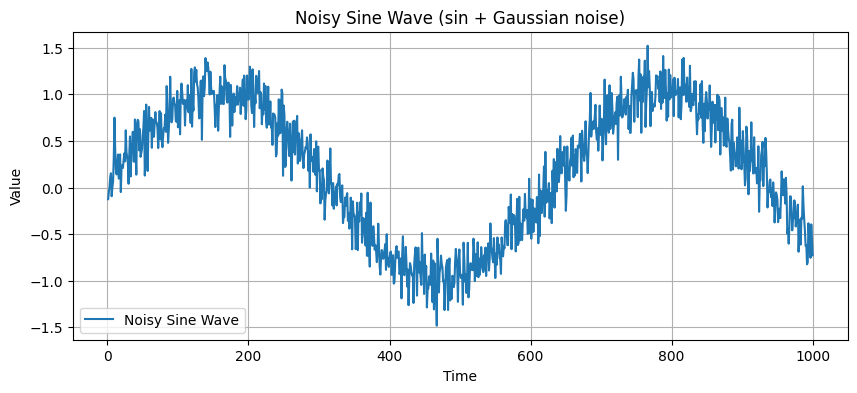

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
T = 1000 # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.figure(figsize=(10, 4))
plt.plot(time.numpy(), x.numpy(), label='Noisy Sine Wave')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Noisy Sine Wave (sin + Gaussian noise)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from torch.utils.data import TensorDataset, DataLoader
tau = 4 #用过去4个点来预测当前值
features = torch.zeros((T - tau, tau)) #（996,4）
for i in range(tau):
    features[:, i] = x[i:T - tau + i] #填充后每一行代表一个时间点对应参考的四个特征
labels = x[tau:].reshape((-1, 1))       #举例：对应的标签是列是[x4,x999]
batch_size, n_train = 16, 600
train_dataset = TensorDataset(features[:n_train], labels[:n_train])
test_dataset = TensorDataset(features[n_train:], labels[n_train:])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 初始化网络权重的函数
def init_weights(m):
 if type(m) == nn.Linear:
  nn.init.xavier_uniform_(m.weight)
 # 一个简单的多层感知机
def get_net():
 net = nn.Sequential(nn.Linear(4, 10),
 nn.ReLU(),
 nn.Linear(10, 1))
 net.apply(init_weights)
 return net
# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none') #这表示 loss 不会自动求平均，也不会求和，而是返回每个元素的平方误差

def evaluate_loss(net, data_iter, loss):
  net.eval()
  total_loss, total_count = 0, 0
  with torch.no_grad():
    for X, y in data_iter:
      l = loss(net(X), y)
      total_loss += l.sum().item()
      total_count += y.numel()
  net.train()
  return total_loss / total_count

def train(net, train_loader, loss, epochs, lr):
 trainer = torch.optim.Adam(net.parameters(), lr)
 for epoch in range(epochs):
  for X, y in train_loader:
    trainer.zero_grad()
    l = loss(net(X), y)
    l.sum().backward()
    trainer.step()
  print(f'epoch {epoch + 1}, ' f'loss: {evaluate_loss(net, train_loader, loss):f}')

net = get_net()
train(net, train_loader, loss, 5, 0.01)

epoch 1, loss: 0.060405
epoch 2, loss: 0.047334
epoch 3, loss: 0.043347
epoch 4, loss: 0.042863
epoch 5, loss: 0.042130


以下是文本的常见预处理步骤。这些步骤通常包括：
1. 将文本作为字符串加载到内存中。
2. 将字符串拆分为词元（如单词和字符）。
3. 建立一个词表，将拆分的词元映射到数字索引。
4. 将文本转换为数字索引序列，方便模型操作。

In [1]:
!pip install d2l --upgrade

In [2]:
import collections
import re
from d2l import torch as d2l
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
 '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine():
 """将时间机器数据集加载到文本行的列表中"""
 with open(d2l.download('time_machine'), 'r') as f:
  lines = f.readlines()
 return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [5]:
#拆解成词元
def tokenize(lines, token='word'):
 """将文本行拆分为单词或字符词元"""
 if token == 'word':
  return [line.split() for line in lines]
 elif token == 'char':
  return [list(line) for line in lines]
 else:
  print('错误：未知词元类型：' + token)
tokens = tokenize(lines)
for i in range(11):
  print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [6]:
#构建词表
import collections
import re
from d2l import torch as d2l
def count_corpus(tokens):
 """统计词元的频率"""
 # 这里的tokens是1D列表或2D列表
 if len(tokens) == 0 or isinstance(tokens[0], list):
  # 将词元展平为一个列表
  flattened = []
  for line in tokens:
    for token in line:
      flattened.append(token)
  tokens = flattened

 return collections.Counter(tokens) #collections.Counter()是Python标准库中的一个工具，用于统计每个元素出现的次数，返回一个类似字典的对象。

class Vocab:
 """文本词表"""
 def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
  '''
  tokens：二维或一维词列表，比如 [['hello', 'world'], ['hello', 'AI']]

  min_freq：出现次数少于这个数的词就会被忽略（过滤低频词）

  reserved_tokens：你想保留的一些特殊词，比如 <pad>, <cls>...

  '''
  if tokens is None:
    tokens = []
  if reserved_tokens is None:
    reserved_tokens = []
  # 按出现频率排序
  counter = count_corpus(tokens)
  self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True) #从大到小
  # 处理未知词元和想保留的特殊词
  self.idx_to_token = ['<unk>'] + reserved_tokens #列表
  self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)} #字典
  # 筛出低频词
  for token, freq in self._token_freqs:
    if freq < min_freq:
      break
    if token not in self.token_to_idx:
      self.idx_to_token.append(token)
      self.token_to_idx[token] = len(self.idx_to_token) - 1
 def __len__(self):
  return len(self.idx_to_token)
 def __getitem__(self, tokens):
  #单个词
  if not isinstance(tokens, (list, tuple)):
    return self.token_to_idx.get(tokens, self.unk)
  #列表或者元组
  return [self.__getitem__(token) for token in tokens]
 def to_tokens(self, indices):
  if not isinstance(indices, (list, tuple)):
    return self.idx_to_token[indices]
  return [self.idx_to_token[index] for index in indices]
 def unk(self):
  return 0
 def token_freqs(self):
  return self._token_freqs
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [12]:
for i in range(0,10):
  print(tokens[i])
  print(vocab[tokens[i]])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[1, 19, 50, 40, 2183, 2184, 400]
[]
[]
[]
[]
[]
[]
[]
[]
['i']
[2]
[]
[]
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
[1, 19, 71, 16, 37, 11, 115, 42, 680, 6, 586, 4, 108]
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
[7, 1420, 5, 2185, 587, 6, 126, 25, 330, 127, 439, 3]


In [7]:
def load_corpus_time_machine(max_tokens=-1):
 """返回时光机器数据集的词元索引列表和词表 呈现字母出现的顺序"""
 lines = read_time_machine()
 tokens = tokenize(lines, 'char')
 vocab = Vocab(tokens)
 corpus = []
 for line in tokens:
  for token in line:
    corpus.append(vocab[token])
 if max_tokens > 0:
  corpus = corpus[:max_tokens]
 return corpus, vocab
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [8]:
tokens = tokenize(read_time_machine())
 # 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

**随机采样**   
在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。在迭代过程中，来自两个相邻的、随机
的、小批量中的子序列不一定在原始序列上相邻。对于语言建模，目标是基于到目前为止我们看到的词元来
预测下一个词元，因此标签是移位了一个词元的原始序列。

In [16]:
import random
import torch
from torch import nn
import matplotlib.pyplot as plt
#随机取样的核心就是开始的corpus范围不同
def seq_data_iter_random(corpus, batch_size, num_steps):
 """使用随机抽样生成一个小批量子序列"""
 # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
 corpus = corpus[random.randint(0,num_steps - 1):]
 num_subseqs = (len(corpus) - 1) // num_steps #求划分的序列数目
 # 长度为num_steps的子序列的起始索引(所有的)
 initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
 # 打乱
 random.shuffle(initial_indices)

 def data(pos):
  return corpus[pos: pos + num_steps]
 num_batches = num_subseqs // batch_size
 for i in range(0, batch_size * num_batches, batch_size):
  # 在这里，initial_indices包含子序列的随机起始索引
  initial_indices_per_batch = initial_indices[i: i + batch_size] #以每个batch为计数单位
  X = [data(j) for j in initial_indices_per_batch]
  Y = [data(j+1) for j in initial_indices_per_batch]
  yield torch.tensor(X), torch.tensor(Y) #每次调用这个生成器，都会返回一批训练样本 X, Y，供模型使用。


my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
 print('X: ', X, '\nY:', Y)

X:  tensor([[22, 23, 24, 25, 26],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[23, 24, 25, 26, 27],
        [28, 29, 30, 31, 32]])
X:  tensor([[17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [13, 14, 15, 16, 17]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [ 2,  3,  4,  5,  6]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [ 3,  4,  5,  6,  7]])


**顺序分区**   
在迭代过程中，除了对原始序列可以随机抽样外，我们还可以保证两个相邻的小批量中的子序列在原始序列
上也是相邻的。这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。

**1、随机偏移**	避免每次都从同样位置取数据   
**2、裁剪对齐**	保证 reshape 不出错   
**3、reshape**	组织成批量的序列   
**4、分批输出**	分时间步长输出多个小批数据

In [15]:
import random
import torch

def seq_data_iter_sequential(corpus, batch_size, num_steps):
 """使用顺序分区生成一个小批量子序列"""
 # 从随机偏移量开始划分序列
 offset = random.randint(0, num_steps)
 num_tokens = ((len(corpus)- offset- 1) // batch_size) * batch_size
 Xs = torch.tensor(corpus[offset: offset + num_tokens])
 Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
 Xs, Ys = Xs.reshape(batch_size,-1), Ys.reshape(batch_size,-1)
 num_batches = Xs.shape[1] // num_steps
 for i in range(0, num_steps * num_batches, num_steps):
  X = Xs[:, i: i + num_steps]
  Y = Ys[:, i: i + num_steps]
  yield X, Y
my_seq = list(range(35))
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
  print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [24, 25, 26, 27, 28]])
X:  tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [29, 30, 31, 32, 33]])


In [18]:
class SeqDataLoader:
  def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
    if use_random_iter:
      self.data_iter_fn = d2l.seq_data_iter_random
    else:
      self.data_iter_fn = d2l.seq_data_iter_sequential
    self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
    self.batch_size, self.num_steps = batch_size, num_steps
  def __iter__(self):
    return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
 """返回时光机器数据集的迭代器和词表"""
 data_iter = SeqDataLoader(
 batch_size, num_steps, use_random_iter, max_tokens) #使用随机采样
 return data_iter, data_iter.vocab  #同时返回迭代器和词表

RNN的核心数学公式：   
$\mathbf{H}_t$表示时间步t的隐藏变量   
公式为：
$$  
\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh} + \mathbf{b}_h)
$$   
输出层公式为：
$$
\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q
$$


困惑度：   
$$
\text{Perplexity}(w_1, w_2, \ldots, w_T) = \exp\left( -\frac{1}{T} \sum_{t=1}^{T} \log P(w_t \mid w_1, \ldots, w_{t-1}) \right)
$$
困惑度的最好的理解是“下一个词元的实际选择数的调和平均数”。
- 在最好的情况下，模型总是完美地估计标签词元的概率为1。在这种情况下，模型的困惑度为1。
- 在最坏的情况下，模型总是预测标签词元的概率为0。在这种情况下，困惑度是正无穷大。
- 在基线上，该模型的预测是词表的所有可用词元上的均匀分布。在这种情况下，困惑度等于词表中唯一
词元的数量。事实上，如果我们在没有任何压缩的情况下存储序列，这将是我们能做的最好的编码方式。因此，这种方式提供了一个重要的上限，而任何实际模型都必须超越这个上限。